# **Decision Trees for Gender Classification**

## **Introduction and Overview**

This project leverages decision trees to classify gender based on biological and activity traits. Decision trees are an interpretable machine learning model often used in feature selection and data-driven decision-making. The analysis explores key features, such as height and activity patterns, and evaluates their predictive importance in distinguishing between male and female classifications.

## About the dataset

This project uses a dataset obtained from the JSE Data Archive that contains biological and self-reported activity traits of a sample of college students at a single university uploaded in 2013. The study associated with these data focused on exploring if a correspondence exists between eye color and other traits. Here I will be using gender as the target/label.

## **Table of Contents**
1. Data Loading and Exploration
2. Initial Analysis
3. Feature Engineering
4. Decision Tree Training and Evaluation
5. Model Comparisons
6. Conclusion and Future Work

## **1. Data Loading and Exploration**

### Loading the Data

In [8]:
# Importing Libraries
from collections import Counter
from itertools import combinations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [9]:
!wget -nc http://quadro.ist.berkeley.edu:1331/eye_color.csv
!ls
df = pd.read_csv('eye_color.csv')
# remove NA's and reset the index
df = df.dropna(axis=0, how='any', subset=None, inplace=False)
df = df.reset_index(drop=True)

df.head()

File ‘eye_color.csv’ already there; not retrieving.

'BLR Interview'				     eye_color.csv
'Data100 Projects'			     FRENCH-43
 Decision_tree_gender_classification.ipynb   WHERE-ARE-MY-FILES.txt
 Econ140


,gender,age,year,eyecolor,height,miles,brothers,sisters,computertime,exercise,exercisehours,musiccds,playgames,watchtv
0,female,18,first,hazel,68.0,195.0,0,1,20.0,Yes,3.0,75.0,6.0,18.0
1,male,20,third,brown,70.0,120.0,3,0,24.0,No,0.0,50.0,0.0,3.0
2,female,18,first,green,67.0,200.0,0,1,35.0,Yes,3.0,53.0,8.0,1.0
3,male,23,fourth,hazel,74.0,140.0,1,1,5.0,Yes,25.0,50.0,0.0,7.0
4,female,19,second,blue,62.0,60.0,0,1,5.0,Yes,4.0,30.0,2.0,5.0


### Data Summary and Visualization

In [10]:
# Summary statistics
print(df.describe())

               age       height         miles     brothers      sisters  \
count  1988.000000  1988.000000   1988.000000  1988.000000  1988.000000   
mean     20.640845    68.305332    310.898667     1.051811     1.014085   
std       2.789870     4.207721   1078.605752     1.024526     0.978790   
min      17.000000    44.000000      0.000000     0.000000     0.000000   
25%      19.000000    65.000000     50.000000     0.000000     0.000000   
50%      20.000000    68.000000    130.000000     1.000000     1.000000   
75%      21.000000    71.000000    210.000000     2.000000     1.000000   
max      56.000000    85.000000  25000.000000     6.000000     7.000000   

       computertime  exercisehours     musiccds    playgames      watchtv  
count   1988.000000    1988.000000  1988.000000  1988.000000  1988.000000  
mean      12.270121       3.685362    81.542757     3.123390     9.405936  
std       11.293750       4.199956   117.789687     5.190163     8.256714  
min        0.000000 

Here we can see that the dataset primarily contains younger individuals (mean age: 20.64 years), with heights ranging symmetrically around a mean of 68.31 inches. Height shows significant variability, making it a strong predictor for gender classification. We can also see the behavioral features such as computer time (mean: 12.27 hours), exercise hours (mean: 3.69 hours), and media engagement (e.g., music CDs, gaming, and TV hours) exhibiting high variability, which indicates the diverse lifestyles among students and can have moderate prediction power.

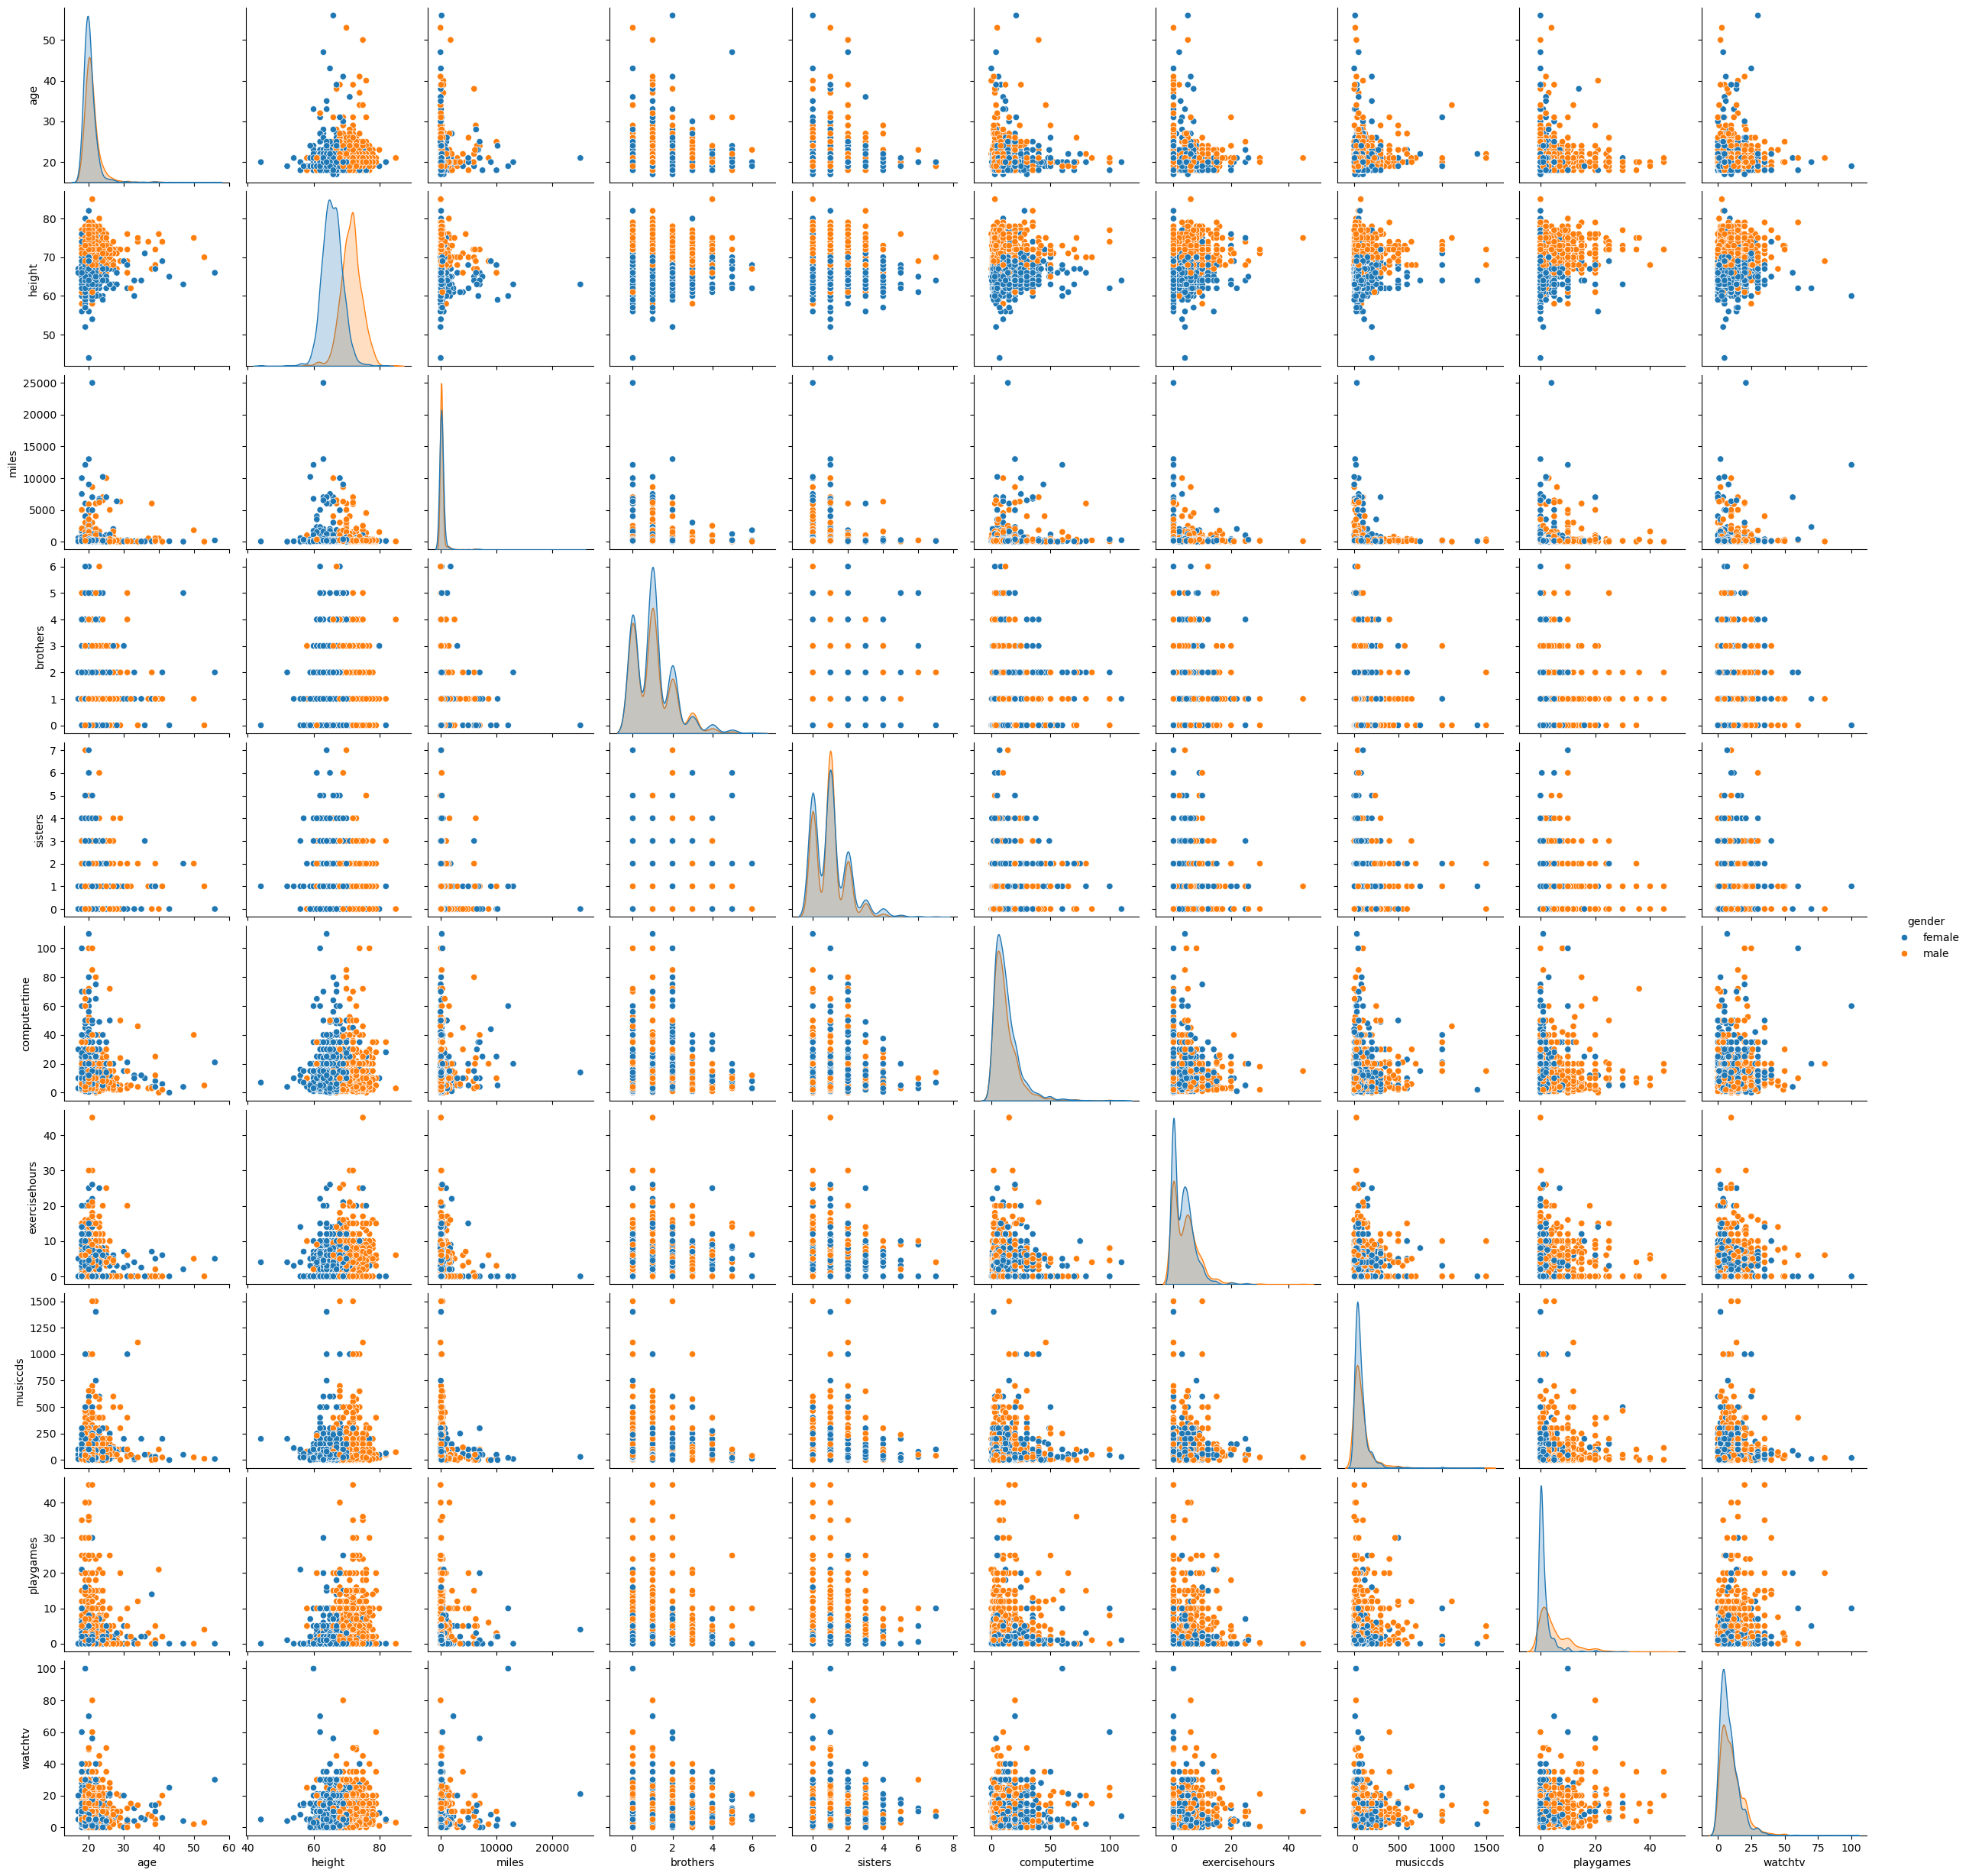

In [9]:
# Visualizing feature distributions
sns.pairplot(df, hue='gender', diag_kind='kde')
plt.show()

This pairplot illustrates a clear distinction in the distribution between height and gender. Males generally tend to have a higher range of height compared to females, making it a strong predictor for gender classification. There is also a notable trend in exercise hours, although both genders seem to overlap, males appear to have more instances of higher exercise hours compared to females. Similarly, the visual shows that males tend to spend more hours playing games compared to females.

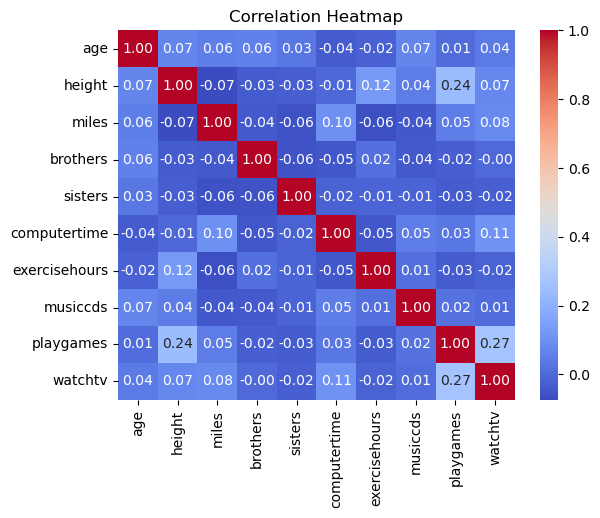

In [10]:
# Correlation heatmap for numeric features
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
correlations = df[numeric_features].corr()
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

## **2. Initial Analysis**

### Gender Distribution

gender
female    1078
male       910
Name: count, dtype: int64


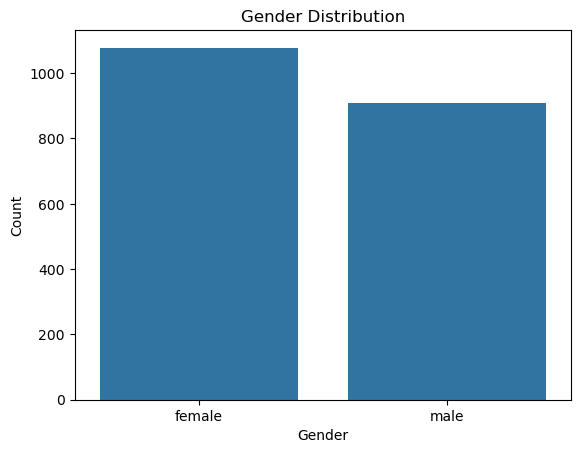

In [11]:
gender_counts = df['gender'].value_counts()
print(gender_counts)

# Visualization
sns.barplot(x=gender_counts.index, y=gender_counts.values)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

### Gini Index for Gender

The Gini Index is used in decision trees to determine the best split at each node. Splits are evaluated based on their ability to reduce impurity, with lower Gini values indicating better splits. By minimizing the Gini Index, decision trees ensure that nodes are as homogenous as possible.

In [12]:
def calculate_gini(proportions):
    return 1 - sum(p ** 2 for p in proportions)

# Calculate Gini Index
gender_proportions = gender_counts / gender_counts.sum()
gini_index = calculate_gini(gender_proportions)
print("Overall Gini Index:", gini_index)

Overall Gini Index: 0.4964292799047807


In the given example, the Gini Index of 0.496 suggests that the dataset is fairly balanced in terms of gender distribution but not perfectly so. The index will guide the decision tree in selecting the features or thresholds that can improve the separation of male and female classes.

## **3. Feature Engineering**

### Best Split for Numeric Feature: Height

In [23]:
def calculate_split_gini(feature, target, split_point):
    left = target[feature <= split_point]
    right = target[feature > split_point]
    left_gini = calculate_gini(left.value_counts(normalize=True))
    right_gini = calculate_gini(right.value_counts(normalize=True))
    left_weight = len(left) / len(target)
    right_weight = len(right) / len(target)
    return left_weight * left_gini + right_weight * right_gini

print("Best Height Split:", best_split)
print("Gini Index at Best Split:", min_gini)

Best Height Split: 68.0
Gini Index at Best Split: 0.2655288120702919


### Evaluate potential split points

In [14]:
heights = df['height'].unique()
best_split = None
min_gini = float('inf')
for split in heights:
    split_gini = calculate_split_gini(df['height'], df['gender'], split)
    if split_gini < min_gini:
        min_gini = split_gini
        best_split = split

print("Best Height Split:", best_split)
print("Gini Index at Best Split:", min_gini)

Best Height Split: 68.0
Gini Index at Best Split: 0.2655288120702919


### Best Split for Categorical Feature: Eye Color

In [24]:
def evaluate_categorical_splits(feature, target):
    unique_categories = feature.unique()
    best_gini = float('inf')
    best_split = None
    
    for category in unique_categories:
        left = target[feature == category]
        right = target[feature != category]
        left_gini = calculate_gini(left.value_counts(normalize=True))
        right_gini = calculate_gini(right.value_counts(normalize=True))
        left_weight = len(left) / len(target)
        right_weight = len(right) / len(target)
        split_gini = left_weight * left_gini + right_weight * right_gini
        
        if split_gini < best_gini:
            best_gini = split_gini
            best_split = category

    return best_split, best_gini
    
# Evaluate eye color
best_eye_color_split, gini_at_split = evaluate_categorical_splits(df['eyecolor'], df['gender'])
print("Best Eye Color Split:", best_eye_color_split)
print("Gini Index at Best Split:", gini_at_split)

Best Eye Color Split: green
Gini Index at Best Split: 0.4930915729509777


## **4. Decision Tree Training and Evaluation**

### Training the Decision Tree

In [25]:
vectorizer = DictVectorizer()
features = vectorizer.fit_transform(df.drop('gender', axis=1).to_dict('records')).toarray()
labels = pd.get_dummies(df['gender']).values[:, 0]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Train decision tree
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
train_acc = clf.score(X_train, y_train)
test_acc = clf.score(X_test, y_test)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

Training Accuracy: 0.8713156002875629
Test Accuracy: 0.8408710217755444


### Visualizing the Decision Tree

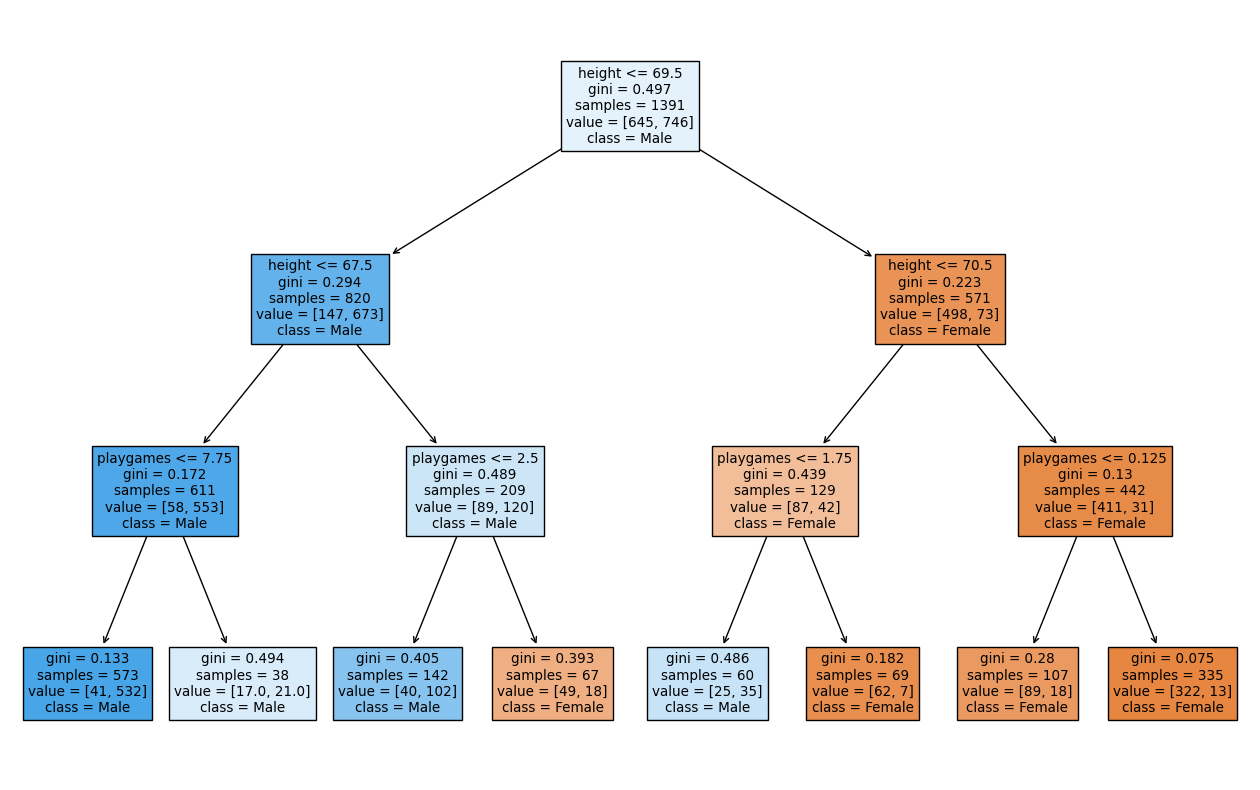

In [17]:
# Visualize decision tree
plt.figure(figsize=(16, 10))
tree.plot_tree(clf, feature_names=vectorizer.feature_names_, class_names=['Female', 'Male'], filled=True)
plt.show()

I used the decision tree classifier to generate the above tree graph where each node, not including the root node, classifies my data to determine if based on the input features, individuals would be classified as female or male. My decision tree uses two primary features, height and games. The tree is fairly straight-forward, starting from the root node, our data will split based on the "best-split height" and if input data satisfies the condition, it will go left node, otherwise continue to the right node. Notice that samples decrease as our decision tree splits deeper or has more nodes. Samples are the number of the total data per node where value is a list containing the account of our dataset of females and males. The gini feature will tell us how impure our data within each node is and ultimately we want to achieve a low or minimize the gini index. Finally, each node will inform if the individual would belong to a female or male class.

## **5. Model Comparisons**

### Random Forest Classifier

In [18]:
rf_clf = RandomForestClassifier(max_depth=3, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, random_state=42)

In [19]:
# Evaluate
rf_train_acc = rf_clf.score(X_train, y_train)
rf_test_acc = rf_clf.score(X_test, y_test)
print("Random Forest Training Accuracy:", rf_train_acc)
print("Random Forest Test Accuracy:", rf_test_acc)

Random Forest Training Accuracy: 0.879942487419123
Random Forest Test Accuracy: 0.8458961474036851


### Classification Report

In [26]:
# Classification report for decision tree
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred))

Decision Tree Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.76      0.81       265
        True       0.82      0.91      0.86       332

    accuracy                           0.84       597
   macro avg       0.85      0.83      0.84       597
weighted avg       0.84      0.84      0.84       597



## **6. Conclusion and Future Work**

### Summary of Findings
- **Key Features:** Height and activity-related metrics (e.g., play time) were critical in determining gender classification.
- **Model Performance:** The decision tree achieved a test accuracy of 0.8408, while the random forest outperformed it with 0.8458.
